# Imports

In [ ]:
!pip uninstall deepdowmine -y
!pip install git+https://github.com/dsman1823/deepdowmine.git

In [1]:
import numpy as np
import pandas as pd
import torch

from matplotlib import pyplot as plt
from deepdowmine.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale, SeqRigidDataLoader, WeeklyRigidDataLoader
from deepdowmine.losses import MeanReturns, SharpeRatio, MaximumDrawdown, StandardDeviation
from deepdowmine.nn import DenseNetFullOpti2, DenseNetMinVar2, RnnNetMinVar2, RnnNetMinVar, DenseNetFullOpti2, RnnNetFullOpti2
from deepdowmine.experiments import Run
from deepdowmine.callbacks import EarlyStoppingCallback
from deepdowmine.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap




# Setup

In [58]:
np.random.seed(5)
returns = pd.read_csv('old_train_data_1.csv', index_col = 0).to_numpy()[1:]

In [59]:
len(returns)

3008

In [60]:
n_timesteps, n_assets = len(returns), 5#11**4, 450

#returns = np.random.normal(0, .2, size = (n_timesteps, n_assets))

lookback, gap, horizon = 50, 0, 5# 40, 0, 5   loss=-0.09645, test_loss=-0.08003]
n_samples = n_timesteps - lookback - horizon - gap + 1

indices = np.arange(n_samples)
split_ix = int(n_samples * 0.8)
indices_train = indices[:split_ix]
indices_test = indices[split_ix:]


# print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
#                                                      indices_test[0], indices_test[-1]))

In [61]:
def transform_returns_to_Xy_tensors(returns, lookback, n_timesteps, horizon, gap):
    X_list, y_list = [], []

    for i in range(lookback, n_timesteps - horizon - gap + 1):
        X_list.append(returns[i - lookback: i, :])
        y_list.append(returns[i + gap: i + gap + horizon, :])

    X = np.stack(X_list, axis=0)[:, None, ...]
    y = np.stack(y_list, axis=0)[:, None, ...]

    return X, y

In [62]:

#returns = np.random.normal(0, .2, size = (n_timesteps, n_assets))

# X_list, y_list = [], []

# for i in range(lookback, n_timesteps - horizon - gap + 1):
#     X_list.append(returns[i - lookback: i, :])
#     y_list.append(returns[i + gap: i + gap + horizon, :])

# X = np.stack(X_list, axis=0)[:, None, ...]
# y = np.stack(y_list, axis=0)[:, None, ...]
X, y = transform_returns_to_Xy_tensors(returns, lookback, n_timesteps, horizon, gap)
#print('X: {}, y: {}'.format(X.shape, y.shape))

# means, stds = prepare_standard_scaler(X, indices=indices_train)
# print('mean: {}, std: {}'.format(means, stds))

dataset = InRAMDataset(X, y)
#, transform=Scale(means, stds))

torch.manual_seed(32)

dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)

dataloader_test = SeqRigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)

dataloader_train_for_retrain = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)
dataloader_test_for_retrain = SeqRigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)


# Network setup

In [63]:
network = RnnNetFullOpti2(5,  0.2, 'diagonal', 1)

In [64]:

print(network)
network = network.train()
loss = SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={
              'test': dataloader_test,
              'train': dataloader_train
              },
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True, lr=0.0005),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=10)]) #15 # patience controlls amount offffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffrfvd

RnnNetFullOpti2(
  (norm_layer): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (transform_layer): RNN(5, 5, batch_first=True)
  (linear_for_cov): Linear(in_features=250, out_features=250, bias=True)
  (covariance_layer): CovarianceMatrix()
  (portfolio_layer): ThesisMarkowitzFullOpti(
    (cvxpylayer): CvxpyLayer()
  )
)


# Train start

In [ ]:
history = run.launch(150)
torch.save(network.state_dict(), 'network.pth')

Epoch 0:   0%|                                                                                  | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 1:   0%|                                                                                  | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 11:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 12:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 22:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 23:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 33:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 34:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 44:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 45:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 55:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 56:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 66:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 67:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 77:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 78:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 88:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 89:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 99:   0%|                                                                                 | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 100:   0%|                                                                                | 0/74 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

## Retrain the model on validation set with limited amount of epochs, and limited learning rate

In [14]:
network_retrained = RnnNetFullOpti2(5,  0.2, 'diagonal', 1)

network_retrained.load_state_dict(network.state_dict())

##!!!!!!!!!!!!!!!!!!!!!!!!
# state_dict = torch.load('min_var_1.pth')
# network_retrained.load_state_dict(state_dict)
# ####


print(network_retrained)
network_retrained = network_retrained.train()
loss = SharpeRatio()
run = Run(network_retrained,
          loss,
          dataloader_train_for_retrain,
          val_dataloaders={
              'train': dataloader_train_for_retrain,
              'test': dataloader_test_for_retrain
              },
          optimizer=torch.optim.Adam(network_retrained.parameters(), amsgrad=True, lr=0.0005),
)

RnnNetFullOpti2(
  (norm_layer): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (transform_layer): RNN(5, 5, batch_first=True)
  (linear_for_cov): Linear(in_features=250, out_features=250, bias=True)
  (covariance_layer): CovarianceMatrix()
  (portfolio_layer): ThesisMarkowitzFullOpti(
    (cvxpylayer): CvxpyLayer()
  )
)


In [15]:
history_retrain = run.launch(30)
torch.save(network_retrained.state_dict(), 'network_retrained.pth')

Epoch 0:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 1:   0%|                                                                                  | 0/22 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 11:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 12:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

Epoch 22:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Epoch 23:   0%|                                                                                 | 0/22 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible a

In [18]:
network.gamma

Parameter containing:
tensor([1.6510], requires_grad=True)

# Check model perfomance

In [ ]:
  # network = LstmNetMinVar(5)
  # network.load_state_dict(torch.load(fr'network_2.pth'))

In [53]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

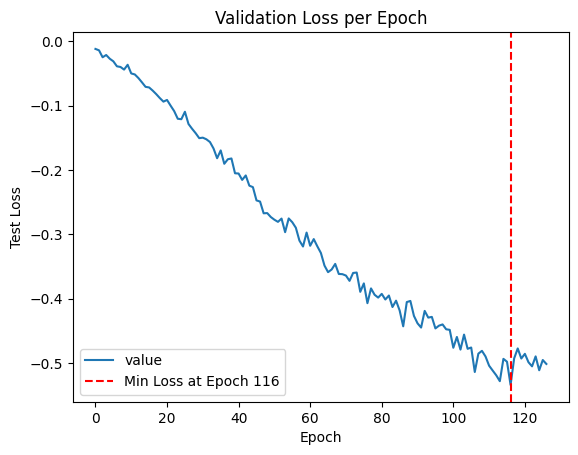

In [54]:
mean_test_loss = per_epoch_results.mean()['test']['loss']['network'] # tmp

# Plotting the mean test loss per epoch
mean_test_loss.plot()

# Finding the epoch with the minimum test loss
min_loss_epoch = mean_test_loss.idxmin()
min_loss_value = mean_test_loss.min()

# Adding a red vertical line at the epoch with minimum test loss
plt.axvline(x=min_loss_epoch, color='r', linestyle='--', label=f'Min Loss at Epoch {min_loss_epoch}')

# Adding some labels and title for clarity
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Show the plot
plt.show()

In [12]:
per_epoch_results.mean()['test']['loss']['network'].mean()

-0.25629872

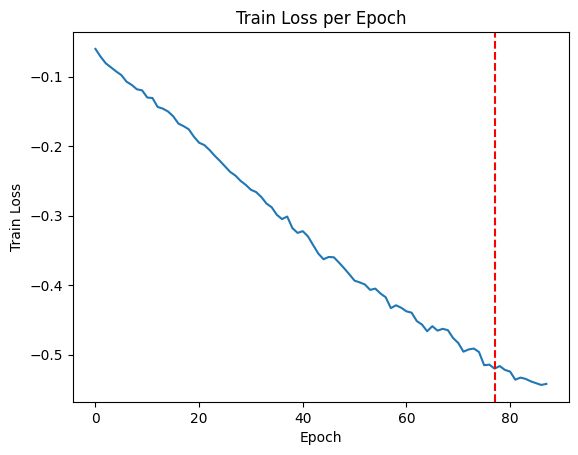

In [13]:
mean_train_loss = per_epoch_results.mean()['train']['loss']['network']

# Plotting the mean test loss per epoch
mean_train_loss.plot()



# Adding some labels and title for clarity
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss per Epoch')
plt.axvline(x=min_loss_epoch, color='r', linestyle='--', label=f'The best model {min_loss_epoch}')

# Show the plot
plt.show()

In [ ]:
network.tmp['output'].shape

# Compute validation factor

In [55]:
X_tensor = torch.tensor(X[indices_test], dtype=torch.float32)
y_tensor = torch.tensor(y[indices_test], dtype=torch.float32)

In [56]:
weights = network(X_tensor)
ewp = weights.new_full(weights.shape, 0.2)

C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [57]:
loss(weights, y_tensor).mean()  /  loss(ewp, y_tensor).mean()

tensor(0.7642, grad_fn=<DivBackward0>)